aggiungere https://www.istat.it/it/metodi-e-strumenti/web-service-sdmx

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
def calc_larg(val):

    val_sep = val.split("-")
    l = (int(val_sep[1]) - int(val_sep[0]))
    return l
'''def scale(x, sf):
    global scalepars_min_x, scalepars_max_xp
    scalepars_min_x = np.min(x)
    x_sc = x-scalepars_min_x
    scalepars_max_xp = np.max(x_sc)
    x_sc = x_sc/scalepars_max_xp
    x_sc *=sf
    return x_sc'''

def scale(x, sf, scalepars_min_x=None, scalepars_max_xp=None):
    if scalepars_min_x is None:
        scalepars_min_x = np.min(x)
    x_sc = x-scalepars_min_x
    if scalepars_max_xp is None:
        scalepars_max_xp = np.max(x_sc)
    x_sc = x_sc/scalepars_max_xp
    x_sc *=sf
    return x_sc, scalepars_min_x, scalepars_max_xp

'''def scale_back(x, sf):
    global scalepars_min_x, scalepars_max_xp
    
    x_sc = x/sf
    x_sc *= scalepars_max_xp
    x_sc = x_sc+scalepars_min_x
    return x_sc'''

def scale_back(x, scalepars_min_x, scalepars_max_xp):
    #global scalepars_min_x, scalepars_max_xp
    
    x_sc = x/np.max(x)
    x_sc *= scalepars_max_xp
    x_sc = x_sc+scalepars_min_x
    return x_sc

def calc_sq_diff(a, b):
    return np.sum(np.square(a-b))

no_tax = 8.174
scaglioni = np.array([ 0, 15, 28, 55, 75])
aliquote = np.array([ .23, .27, .38, .41, .43])
base = np.array([ 0, 3.450, 6.960, 17.220, 25.420])

def calc_irpef(reddito, solo_aliquota = False):
    if reddito <= no_tax:
        return 0
    
    for i_s, s in enumerate( scaglioni):
        b = base[i_s-1]
        a = aliquote[i_s-1]
        #a = aliquote[i_s]
        if reddito > s:
        #if reddito > scaglioni[i_s +1] :
            continue
            
        else:
            #print ("reddito", reddito, "scaglione", s, "aliquota", a, "base", b, "sttraggo", scaglioni[i_s-1])
            if not solo_aliquota:
                return  b + a * (reddito - scaglioni[i_s-1])
            else:
                return a
    return base[-1] + aliquote[-1] * (reddito - scaglioni[-1])

## Studio redditi dichiarati

In [2]:
# file preso da https://www1.finanze.gov.it/finanze3/analisi_stat/index.php?tree=2018AAPFTOT020602&export=0&media=media&page=1&personalizza=no
'''Tipo di imposta : IRPEF

Modello : Persone fisiche totali

Tipologia contribuente : Tutte le tipologie di contribuenti

Tematica : Calcolo dell'IRPEF

Classificazione : Classi di reddito complessivo in euro

Ammontare e media espressi in : Migliaia di euro
'''
df = pd.read_csv("irpef2.csv", delimiter=";", decimal=",", thousands=".")


In [3]:
'''def calc_vc(val):

    val_sep = val.split("-")
    vc = (int(val_sep[1]) - int(val_sep[0]))/2 + int(val_sep[0])
    return vc
df["valore_centrale"] = df['Codice'].apply(calc_vc)'''


df["larghezza"] = df['Codice'].apply(calc_larg)
df = df[df['Reddito complessivo - Media']<100]

In [4]:
colonne_interessanti = ['Classi di reddito complessivo in euro', 
                        'Numero contribuenti', 
                        'Reddito complessivo - Ammontare',
                       'Reddito complessivo - Media']
df[colonne_interessanti].head()

,Classi di reddito complessivo in euro,Numero contribuenti,Reddito complessivo - Ammontare,Reddito complessivo - Media
0,da 0 a 1.000,2350042,991408,0.42
1,da 1.000 a 1.500,606558,753107,1.24
2,da 1.500 a 2.000,507765,887646,1.75
3,da 2.000 a 2.500,466449,1051872,2.26
4,da 2.500 a 3.000,437705,1203420,2.75


/Users/vincenzo/miniconda3/envs/py37.3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


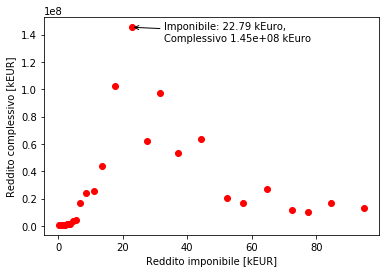

In [5]:
plt.plot(df['Reddito complessivo - Media'], df["Reddito complessivo - Ammontare"], 'ro')
plt.xlabel("Reddito imponibile [kEUR]")
plt.ylabel("Reddito complessivo [kEUR]")

max_at_pos = np.argmax (df["Reddito complessivo - Ammontare"])
x_at_max = df['Reddito complessivo - Media'][max_at_pos]
y_at_max = df["Reddito complessivo - Ammontare"][max_at_pos]
#plt.arrow(x_at_max+2000, y_at_max-0.01e+8, 8000, -0.05e+8, shape='right', head_width = 10000, head_length=10000)
plt.annotate(f"Imponibile: {x_at_max} kEuro,\nComplessivo {y_at_max :1.2e} kEuro", [x_at_max, y_at_max], xytext=(x_at_max+10, y_at_max-0.1e8), arrowprops=dict(arrowstyle="->"))
plt.show()

In [6]:
df['Numero contribuenti'].sum()

39726850

In [7]:
df['area_loc'] = df["larghezza"]* df["Reddito complessivo - Ammontare"]
area_tot = np.sum(df['area_loc'])
area_tot

4200438836500

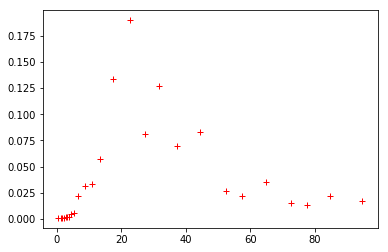

In [8]:
y_norm =  df["Reddito complessivo - Ammontare"]/area_tot
plt.plot(df['Reddito complessivo - Media'], y_norm/np.sum(y_norm), 'r+')

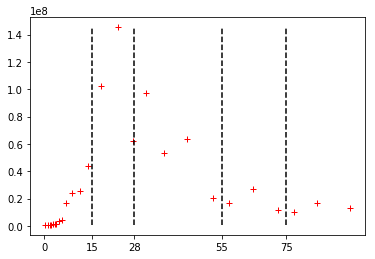

In [9]:
y4plot = df["Reddito complessivo - Ammontare"]#/1e8+2
plt.plot(df['Reddito complessivo - Media'], y4plot, 'r+')

max_y = np.max(y4plot)
min_y = np.min(y4plot)
plt.xticks(scaglioni)
for s in scaglioni:
    if s == 0:
        continue
    plt.plot([s, s], [min_y, max_y], '--', color = 'k')


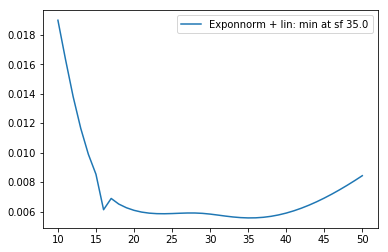

minimo in pos 25: scalato a 35.0 , valore: 0.005567674221433705


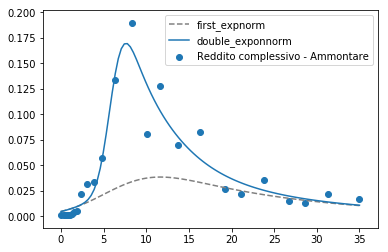

In [13]:
def double_exponnorm(x, p0, p1, p2, p3):
    return stats.exponnorm.pdf(x,  p0, p1, p2) + stats.exponnorm.pdf(x,  p0, p1, p3)

rescaled = np.linspace (10, 50, 41)

sq_errs = []
y2use = y_norm/np.sum(y_norm)
last = 100
tutti_pars = []
for sf in rescaled:
    x_sc, _, _ = scale(df['Reddito complessivo - Media'], sf)
    initial = [5, 3, 0.8, 0.4]
    try:
        pars, cov = curve_fit(double_exponnorm, x_sc, y2use, p0 = initial)#, bounds=bounds)
        tutti_pars .append(pars)
        sq_err = calc_sq_diff(double_exponnorm(x_sc, pars[0], pars[1], pars[2], pars[3]), y2use)
        sq_errs.append(sq_err)
        last = sq_err
    except RuntimeError:
        sq_errs.append(last)
min_at=np.argmin(sq_errs)
sf_scelto = rescaled[min_at]
errore = sq_errs[min_at]
pars_scelti = tutti_pars[min_at]

plt.plot(rescaled, sq_errs, label = f"Exponnorm + lin: min at sf {sf_scelto}")
plt.legend()
plt.show()


print (f"minimo in pos {min_at}: scalato a {sf_scelto} , valore: {errore}")

xt = np.linspace(0, sf_scelto, 100)
y1 = stats.exponnorm.pdf(xt, pars_scelti[0], pars_scelti[1], pars_scelti[2])
yt = double_exponnorm(xt, pars_scelti[0], pars_scelti[1], pars_scelti[2], pars_scelti[3])

plt.plot(xt, y1, '--', label='first_expnorm', color = 'grey')
plt.plot(xt, yt, label="double_exponnorm")

x_sc, sc_min, sc_max = scale(df['Reddito complessivo - Media'], sf_scelto)
plt.scatter(x_sc, y2use)
plt.legend()
plt.show()



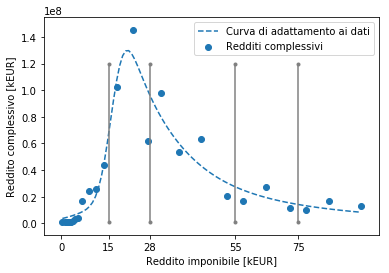

In [14]:
xt = np.linspace(0, sf_scelto, 100)
xt_sc_b = scale_back(xt, sc_min, sc_max)
yt = double_exponnorm(xt, pars_scelti[0], pars_scelti[1], pars_scelti[2], pars_scelti[3])
y_scale_bac_fac = area_tot * np.sum(y_norm)

plt.plot(xt_sc_b, yt*y_scale_bac_fac, "--", label="Curva di adattamento ai dati")
plt.scatter(df['Reddito complessivo - Media'], y2use* y_scale_bac_fac, label="Redditi complessivi")
plt.legend()
plt.xlabel("Reddito imponibile [kEUR]")
plt.ylabel("Reddito complessivo [kEUR]")
max_y = np.max(y2use)
min_y = np.min(y2use)
plt.xticks(scaglioni)
for s in scaglioni:
    if s == 0:
        continue
    plt.plot([s, s], [min_y*y_scale_bac_fac, 1.2e8], '.-', color = 'gray')
plt.show()

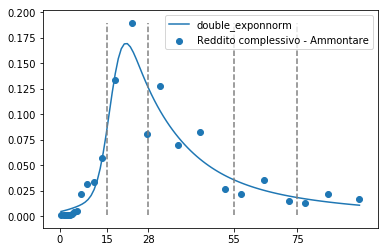

In [20]:

xt = np.linspace(0, sf_scelto, 100)
xt_sc_b = scale_back(xt, sf_scelto)
yt = double_exponnorm(xt, pars_scelti[0], pars_scelti[1], pars_scelti[2], pars_scelti[3])

plt.plot(xt_sc_b, yt, label="double_exponnorm")

x_sc = scale(df['Reddito complessivo - Media'], sf_scelto)
plt.scatter(df['Reddito complessivo - Media'], y2use)
plt.legend()
max_y = np.max(y2use)
min_y = np.min(y2use)
plt.xticks(scaglioni)
for s in scaglioni:
    if s == 0:
        continue
    plt.plot([s, s], [min_y, max_y], '--', color = 'gray')
plt.show()

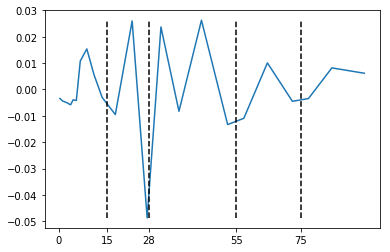

In [15]:
pars_scelti = np.array([3.69957129, 5.87470515, 4.25561841, 1.2146135 ])

baseline =  double_exponnorm(x_sc, pars_scelti[0], pars_scelti[1], pars_scelti[2], pars_scelti[3])
dati_m_baseline = y2use - baseline
x_sc_b = scale_back(x_sc, sc_min, sc_max)
plt.plot(x_sc_b, dati_m_baseline)
max_y = np.max(dati_m_baseline)
min_y = np.min(dati_m_baseline)
plt.xticks(scaglioni)
for s in scaglioni:
    if s == 0:
        continue
    plt.plot([s, s], [min_y, max_y], '--', color = 'k')
plt.show()

## da scaglioni a continua

parametri [-133.88015356   12.95775788    0.37679302]


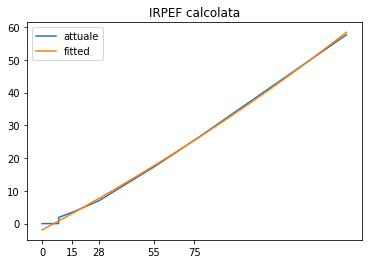

In [112]:
def fit_tax(x, p0, p1, p2):
    return p0+np.exp((x+p1)*p2)



x=np.linspace(0, 150, 10000)
y= []
for x_i in x:
    y.append(calc_irpef(x_i))
    
    
x_sc = scale(x, 1)

pars, covs = curve_fit(fit_tax, x_sc, y)
print('parametri', pars)

plt.plot(x, y, label='attuale')
y_fit = fit_tax(x_sc, *pars)
plt.plot(x, y_fit, label="fitted")
plt.xticks(scaglioni)
plt.title("IRPEF calcolata")
plt.legend()

In [113]:
fit_tax([9], *pars)

array([3784.87741048])

In [111]:
def calc_nuova_irpef(x, p0, p1, p2):
    zeros = x>no_tax
    calculated = fit_tax(x, p0, p1, p2)
    print(zeros*calculated)
    
    
calc_nuova_irpef(np.array([0.3, 9]), *pars)

[   0.         3784.87741048]


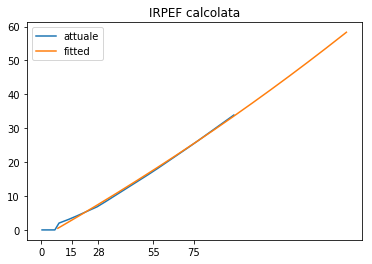

In [101]:

    

vecchia_irpef = []
nuova_irpef = []

x_scaled = scale(df['Reddito complessivo - Media'], 1)
for x_i, x_i_s in zip(df['Reddito complessivo - Media'], x_scaled):
    vecchia_irpef.append(calc_irpef(x_i))
    nuova_irpef.append(fit_tax(x_i_s, *pars))

plt.plot(df['Reddito complessivo - Media'], vecchia_irpef, label='attuale')


plt.plot(x, y_fit, label="fitted")
plt.xticks(scaglioni)
plt.title("IRPEF calcolata")
plt.legend()

0.42 0 0
1.24 0 0
1.75 0 0
2.26 0 0
2.75 0 0
3.25 0 0
3.75 0 0
4.51 0 0
5.51 0 0
6.72 0 0
8.75 2.0125 4.897144848900979
10.99 2.5277000000000003 6.103950813989883
13.51 3.1073 7.472424458559857
17.58 4.146599999999999 9.707043340774163
22.79 5.5533 12.612186554024817
27.44 6.808800000000001 15.24803369246223
31.71 8.3698 17.704735605387782
37.29 10.4902 20.968303850411417
44.26 13.1388 25.131059116676767
52.37 16.220599999999997 30.098013864346512
57.39 18.1999 33.240482212831296
64.68 21.1888 37.89862372746501
72.43 24.366300000000003 42.97644107195083
77.41 26.4563 46.309277751734754
84.66 29.5738 51.26130123255555
94.69 33.886700000000005 58.31254706517694


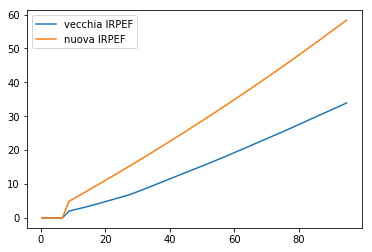

In [99]:
# attuale metodo: stima totale irpef

da_loro = []
calcolati = []

miei = []
rcm_scaled = scale( df['Reddito complessivo - Media'], 1)
for i_rcm, [rcm, rcm_s] in enumerate(zip(df['Reddito complessivo - Media'].values, rcm_scaled)):
    
    loro = df['Reddito complessivo - Ammontare'].iloc[i_rcm]
    da_loro.append(loro)
    
    nc = df['Numero contribuenti'].iloc[i_rcm]
    
    irpef_vecchia = calc_irpef(rcm)# *nc
    calcolati.append(irpef_vecchia)
    
    if rcm < no_tax:
        mio = 0
    else:
        mio = fit_tax(rcm_s, *pars) #* nc
    miei.append(mio)
    print (rcm, irpef_vecchia, mio)
plt.plot(df['Reddito complessivo - Media'], calcolati, label = "vecchia IRPEF")
plt.legend()
plt.plot(df['Reddito complessivo - Media'], miei, label = "nuova IRPEF")
plt.legend()


In [39]:
df

,Classi di reddito complessivo in euro,Codice,Numero contribuenti,Reddito complessivo - Frequenza,Reddito complessivo - Ammontare,Reddito complessivo - Media,Reddito complessivo al netto della cedolare secca - Frequenza,Reddito complessivo al netto della cedolare secca - Ammontare,Reddito complessivo al netto della cedolare secca - Media,Deduzione per abitazione principale - Frequenza,...,Acconti versati - Media,Irpef a credito - Frequenza,Irpef a credito - Ammontare,Irpef a credito - Media,Irpef a debito - Frequenza,Irpef a debito - Ammontare,Irpef a debito - Media,Unnamed: 45,larghezza,area_loc
0,da 0 a 1.000,0-1000,2350042,2350042,991408,0.42,2342704,980993,0.42,653511,...,0.51,216892,145147,0.67,99978,5321,0.05,NaN,1000,991408000
1,da 1.000 a 1.500,1000-1500,606558,606558,753107,1.24,601205,737124,1.23,113829,...,0.43,89818,48967,0.55,39567,4135,0.10,NaN,500,376553500
2,da 1.500 a 2.000,1500-2000,507765,507765,887646,1.75,502166,862503,1.72,80531,...,0.49,87778,48256,0.55,29902,4472,0.15,NaN,500,443823000
3,da 2.000 a 2.500,2000-2500,466449,466449,1051872,2.26,458952,1011882,2.20,73305,...,0.55,93627,52183,0.56,28845,5307,0.18,NaN,500,525936000
4,da 2.500 a 3.000,2500-3000,437705,437705,1203420,2.75,430234,1153729,2.68,74290,...,0.61,99345,57823,0.58,28943,5965,0.21,NaN,500,601710000
5,da 3.000 a 3.500,3000-3500,387175,387175,1257525,3.25,383162,1215157,3.17,67319,...,0.67,96653,56870,0.59,24451,5223,0.21,NaN,500,628762500
6,da 3.500 a 4.000,3500-4000,386519,386519,1450018,3.75,380869,1397711,3.67,65893,...,0.72,100201,62479,0.62,24791,5730,0.23,NaN,500,725009000
7,da 4.000 a 5.000,4000-5000,779400,779400,3515754,4.51,768135,3393699,4.42,135289,...,0.77,222665,154290,0.69,54939,13414,0.24,NaN,1000,3515754000
8,da 5.000 a 6.000,5000-6000,776090,776090,4274598,5.51,764768,4131902,5.40,147773,...,0.84,223229,160563,0.72,62764,16880,0.27,NaN,1000,4274598000
9,da 6.000 a 7.500,6000-7500,2542992,2542992,17084698,6.72,2533930,16895388,6.67,525782,...,0.85,452850,355598,0.79,72023,24646,0.34,NaN,1500,25627047000
